In [214]:
import json
import glob
import os
import geopandas as gpd
import numpy as np
from natsort import natsorted
from pprint import pprint
from shapely.geometry import Point, Polygon
 

In [326]:
image_dir = r'L:\Datasets\ocean_city\processed_json'
extension =  'json'
files = glob.glob(os.path.join(image_dir, "*." + extension))
files = natsorted(files)
files

['L:\\Datasets\\ocean_city\\processed_json\\1_aLH8om-ax5boXJ-hXhFvaQ_123.73.json',
 'L:\\Datasets\\ocean_city\\processed_json\\2_N2TakAa4EvhSCDIb44lEBw_83.71.json',
 'L:\\Datasets\\ocean_city\\processed_json\\3_n4aTTgHhJ2AkPbSg0X3MfA_11.99.json',
 'L:\\Datasets\\ocean_city\\processed_json\\4_7pBBmj5k9GAh1o-n4ctSpQ_56.94.json',
 'L:\\Datasets\\ocean_city\\processed_json\\5_0_Z25VniDxurxsixrPV1LA_33.93.json',
 'L:\\Datasets\\ocean_city\\processed_json\\6_WHxaTCBPZ8v_L8S9Nr24fA_43.17.json',
 'L:\\Datasets\\ocean_city\\processed_json\\8_M3I2qNQeBB2MFg3IHuCbig_104.0.json',
 'L:\\Datasets\\ocean_city\\processed_json\\9_as2lf1LPPhGI1D5DEQtDyA_55.07.json',
 'L:\\Datasets\\ocean_city\\processed_json\\10_piJ3-HBctCPJ9qejZZesEQ_121.73.json',
 'L:\\Datasets\\ocean_city\\processed_json\\11_eD6yAl7EAam1xa8Z6_5Amw_31.49.json',
 'L:\\Datasets\\ocean_city\\processed_json\\13_xixwgkh4GQ9uyj7DHwqcgw_54.73.json',
 'L:\\Datasets\\ocean_city\\processed_json\\14_mvxG0Y8r3Yzv-4e1_6esjQ_115.1.json',
 'L:\\Data

True

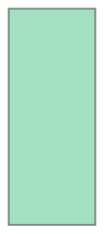

In [444]:
files[-4]

'L:\\Datasets\\ocean_city\\processed_json\\192_SEkj2oHWNtV5D7CMddAKlA_131.13.json'

In [445]:

f = open(files[-4], 'r')
jdata = json.load(f)
f.close() 
shapes = jdata["shapes"]

g = getGeoSeries(shapes)
len(g)

65

# Relationship

## utilities

In [200]:
def fill_relation(subject, predicate, object_):        
    relation = {}

    relation["subject"] = {}
    relation["subject"]["name"] = subject["label"]
    relation["subject"]["object_id"] = subject["object_id"]

    relation["predicate"] = predicate

    relation["object"] = {}
    relation["object"]["name"] = object_["label"]
    relation["object"]["object_id"] = object_["object_id"]
    
    return relation

def createPolygons(shapes):
    polygons = []
    for shape in shapes:
        shape_type = shape["shape_type"]
        points = shape["points"]
#         print("points:", points)
        if len(points) == 2:
            polygon = twoPoints_to_polygon(points[0], points[1])
        elif len(points) > 2:
            polygon = Polygon(points + [points[0]])
            
        polygons.append(polygon)
    return polygons

def getGeoSeries(shapes):
    polygons = createPolygons(shapes)
    return gpd.GeoSeries(polygons)

def getShape_all_id(shapes):
    
    try:
        all_ids = []
        for shape in shapes:
            
            all_ids.append(shape.get('object_id', None))
                          
    except Exception as e:
        print(e)
        return None
#     print(len(all_ids))
    return all_ids
                          
def renewShapeId(shapes):
    for idx, shape in enumerate(shapes):
        shape["object_id"] = idx + 1
        
def twoPoints_to_polygon(p1: (float, float), p2: (float, float))->Polygon:
#     print(p1, p2)
    p3 = (p1[0], p2[1])
    p4 = (p2[0], p1[1])
    return Polygon([p1, p3, p2, p4, p1])

# twoPoints_to_polygon((2076, 2214), (2163, 2431))

def isDuplicateID(id_list):
    id_set = set(id_list)
    if len(id_list) == len(id_set):
        return False
    else:
        return True
    
# isDuplicateID(["2", None, None])

In [253]:
def get_mid_element(a_list):
    if not isinstance(a_list, list):
        return None
    
    cnt = len(a_list)
    if cnt == 0:
        return None
    
    m = cnt % 2
    
    mid_pos = int(cnt/2) + m - 1
    
    return a_list[mid_pos]
    
get_mid_element([1, 2, 4])   

2

In [401]:
def getOverlap(axis_range, number_list):
    overlap_range = []
    number_range = [min(number_list), max(number_list)]
    
    left_end = max(axis_range[0], number_range[0])
    right_end = min(axis_range[1], number_range[1])
    
    if right_end > left_end:
        return [left_end, right_end]
    else:
        return []

def isBetween(axis_range, num):
    if (num < axis_range[1]) and (num > axis_range[0]):
        return True
    else:
        return False

## House location relationship

In [374]:
def init_house_location_relation(shapes, geo_series):        
     
    relation_list = []
    
    # get house idx
    house_idxs = []
    for idx, shape in enumerate(shapes):
        if isHouse(shape['label']):
             house_idxs.append(idx)
    
    house_idxs = np.array(house_idxs)
                
    centroids = geo_series.centroid  
    
    house_centroids = centroids[house_idxs]
    
    sorted_house_x = np.argsort(centroids[house_idxs].x.tolist())
       
    sorted_house_ids = house_idxs[sorted_house_x]
         
    predicate = ''    
   
    for idx, house_id in enumerate(sorted_house_ids[:-1]):
        house_id_right = sorted_house_ids[idx + 1]
        predicate = "in_left_of"
        relation = fill_relation(shapes[house_id], predicate, shapes[house_id_right])
        relation_list.append(relation)  

            
    isPrint = True
    isPrint = False
    if isPrint: 
        if len(relation_list) > 0:
            [print(r['subject']["name"], r['subject']['object_id'], r["predicate"], ":", r['object']["name"], r['object']['object_id']) for r in relation_list]            
        else:
            print("No door is founded in porch:", shapes[idx]["object_id"])
            
        print("")
    
    print("Found %d location relationships between houses.\n" % len(relation_list))      
#     print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))
     
    return relation_list

##  House Components

In [521]:
def isHouseComponents(thing:str)->bool:
    house_components_list = ["deck", "garage", "door", "front-door", "window", "decorative-shutter", "dormer", "vent", "balcony", "basement", "chimney", 
                             "column", "cupola", "facade", "foundation", "gutter", "knewwwall", "overhang-floor", 
                            "patio", "porch", "porch-skirt", "roof", "sidelight", "toplight", "stair", "step", "storey",
                             "terrace", 
                             "vent-turet", "wall"]
    if thing in house_components_list:
        return True
    else:
        return False
    
def init_house_components(idx, shapes, geo_series):
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
    centroids = geo_series.centroid    
    
    centroids.within(geo_series[idx])
#     print("centroids:", centroids)
    insides_idx = centroids[centroids.within(geo_series[idx])].index
#             print(distances)

#     insides_idx = distances[distances < 1].index
#     print("type(insides):", type(list(insides_idx)))
#             print(insides_idx)
    for idx2 in insides_idx:
        thing = shapes[idx2]["label"]
        if isHouseComponents(thing):  
            predicate = "component_of"
            relation = fill_relation(shapes[idx2], predicate, shape)           
            relation_list.append(relation)
            
    isPrint = False
#     isPrint = True
    if isPrint:        
        print("Component of house: ", shape["object_id"])       
        [print(r['subject']["name"], r['subject']['object_id']) for r in relation_list]            
        print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    return relation_list    

def isHouse(label): # may have bug.
    house_name_list = ["bungalow", "house", "building", "single-house", "ranch", "twinhouse", "row-house", "apartment", "condo", "mobile-home", "garage", "shed"]
    if ("house" in label.lower()) or (label.lower() in house_name_list):
        return True
    else:
        return False

## step relation

In [499]:
def init_step_relation(idx, shapes, geo_series):
    
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
#     print(distances)
    
    bounds = geo_series.bounds
    widths = bounds.maxx - bounds.minx
    heights = bounds.maxy - bounds.miny
# #     print(widths)
#     print(heights)
    
    near_ratio = 0.1 # assume that step can connect the object within near_ratio * height.
    
    step_height = heights[idx]
    near_idx = distances[distances < near_ratio * step_height].index
#     print("type(insides):", type((near_idx)))
#     print("near_idx:", near_idx)

    for idx2 in near_idx:
        thing = shapes[idx2]["label"]
        thing_object_id = shapes[idx2]["object_id"]
        object_ = shape["label"]
        object_object_id = shapes[idx]["object_id"]
        
        # connect objects
        connect_objects = ["porch", "deck", "door", "walkway", "landing"]
        
        if thing in connect_objects:             
            predicate = "connect_to"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation)   
            
    isPrint = True
#     isPrint = False

    if isPrint:        
        print(shape["label"],  object_object_id, " connect to:")       
        [print(r['object']["name"], r['object']['object_id']) for r in relation_list]            
        print("")            
    print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    
    return relation_list

## porch relation

In [540]:
def init_porch_relation(idx, shapes, geo_series):
    
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    
    centroids = geo_series.centroid    
    
    # if a door (centroids) inside a porch:
    centroids.within(geo_series[idx])
#     print("centroids:", centroids)
    insides_idx = centroids[centroids.within(geo_series[idx])].index
#     print("idx, shape.label", idx, shape["label"])
#     print("insides_idx:", idx, centroids.within(geo_series[idx]))
 
    predicate = ''
    for idx2 in insides_idx:
        thing = shapes[idx2]["label"]
        if "door" in thing.lower():  
            # connects to door            
            predicate = "connect_to"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation)   
            
    isPrint = True
#     isPrint = False
    if isPrint: 
        if len(relation_list) > 0:
            print(shapes[idx]["label"], shapes[idx]["object_id"])       
            [print(r["predicate"], ":", r['object']["name"], r['object']['object_id']) for r in relation_list]            
        else:
            print("No door is founded in porch:", shapes[idx]["object_id"])
            
#         print("")   
#     print(relation_list)
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))
     
    return relation_list

## sidewalk relationship

In [349]:
def init_sidewalk_relation(idx, shapes, geo_series):
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
#     print(distances)
    
    bounds = geo_series.bounds
    widths = bounds.maxx - bounds.minx
    heights = bounds.maxy - bounds.miny
# #     print(widths)
#     print(heights)
    
    near_ratio = 0.2 # assume that sidewalk can connect the object within near_ratio * height.
    
    sidewalk_height = heights[idx]
    near_idx = distances[distances < near_ratio * sidewalk_height].index
#     print("type(insides):", type((near_idx)))
#     print("near_idx:", near_idx)

    for idx2 in near_idx:
        thing = shapes[idx2]["label"]
        if thing == "road":
            predicate = "along_with"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation) 
  
        # connect objects
        connect_objects = ["door", "walkway", "driveway", "driveway-apron", "curb-cut", "pathway", "step", "stair"]        
        if thing in connect_objects:             
            predicate = "connect_to"
            relation = fill_relation(shape, predicate, shapes[idx2])
            relation_list.append(relation)   
            
        # adjoin objects
        adjoin_objects = ["lawn", "parking-strip", "gravel", "flowerbed", "tree-pit"]        
        if thing in adjoin_objects:             
            predicate = "adjoin_to"
            relation = fill_relation(shapes[idx2], predicate, shape)
            relation_list.append(relation)   
            
        # can connect to road.
            
    isPrint = True
    isPrint = False

    if isPrint:        
        print(shapes[idx]["label"], "id:", shapes[idx]["object_id"])       
        [print(r["predicate"], ":", r['object']["name"], r['object']['object_id']) for r in relation_list]            
        print("")            
    print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    
    return relation_list    

## lawn in the front of house

In [549]:
def init_lawn_relation(idx, shapes, geo_series):
    
    print("Start init_lawn_relation():")
    shape = shapes[idx]
    relation_list = []
    polygon = geo_series[idx]
    distances = geo_series.distance(polygon)
#     print(distances)

    polygons = createPolygons(shapes)
    
    bounds = geo_series.bounds
    widths = bounds.maxx - bounds.minx
    heights = bounds.maxy - bounds.miny
    centroids = geo_series.centroid
    
    lawn_points = polygons[idx].exterior.coords.xy
    lawn_points = np.array(lawn_points).transpose()
#     print("lawn_points:", lawn_points)
     
    lawn_front_points = []  # get the front points of lawn 
    lawn_front_points = lawn_points[lawn_points[:, 1] > centroids[idx].y]
#     print("centroids[idx].y:", centroids[idx].y)
#     print("lawn_front_points:\n", lawn_front_points)
    
  
    house_idxs = []
    for house_id, s in enumerate(shapes):
        if isHouse(s['label']):            
            house_idxs.append(house_id)
#     print(house_idxs)

                
    for house_idx in house_idxs:
#         print("house idx:", house_idx)
        shape_house = shapes[house_idx]
        house_points = polygons[house_idx].exterior.coords.xy
#         house_points = np.array(lawn_points).transpose()
        house_points_x = house_points[0]
    
        house_max_y =  max(house_points[1]) # most front point
#         print("house_max_y:", house_max_y)
        
#         print("house_points:\n", house_points)
        
        lawn_front_points = lawn_front_points[lawn_front_points[:, 1] > house_max_y]
        
        front_facade = [min(house_points_x), max(house_points_x)]   # x range of front facade
#         print("front_facade:", front_facade)

#         print("lawn_front_points:\n", lawn_front_points)
        
        if len(lawn_front_points) > 1:
            
#             print("lawn_front_points:\n", lawn_front_points)
#             print("shapes[house_idx][label]:", shapes[house_idx]["label"], shapes[house_idx]["object_id"])
#             print("front_facade:", front_facade)
            overlap = getOverlap(front_facade, lawn_front_points[:, 0])
#             print("overlap:", overlap)

            overlap_ratio = 0.2 # in x-axis, assume that the front line of lawn overlap with house more overlap_ratio * lawn_width.
            if len(overlap) == 2:
                overlap_len = overlap[1] - overlap[0]
                lawn_width = max(lawn_front_points[:, 0]) - min(lawn_front_points[:, 0])
                if overlap_len / lawn_width > overlap_ratio:
                    predicate = "in_front_of"
                    relation = fill_relation(shape, predicate, shape_house)
                    relation_list.append(relation)             
            
            
    isPrint = True
    isPrint = False

    if isPrint:        
        print(shapes[idx]["label"], shapes[idx]["object_id"])       
        [print(r["predicate"], ":", r['object']["name"],  r['object']['object_id']) for r in relation_list]            
        print("")            
    print("")   
    
    print("Found {} relationships for {} - {}\n".format(len(relation_list), shapes[idx]["label"], shapes[idx]["object_id"]))

    
    return relation_list    

## Init relations

In [530]:
def initRelation(shapes):
    
    walkable_connection_list = []
    infront_of_list = []
    
    relations_list_all = []
    
    geo_series = getGeoSeries(shapes)

    house_location_relations = init_house_location_relation(shapes, geo_series)  
    relations_list_all += house_location_relations
    
    for idx, shape in enumerate(shapes):
        label = shape["label"]
        
        # house components
        if isHouse(label):
            house_relations = init_house_components(idx, shapes, geo_series)
            relations_list_all += house_relations
             
            
        # step connect to porch, walkway, door
        if "step" in label.lower():
            step_relations = init_step_relation(idx, shapes, geo_series)
            relations_list_all += step_relations

        # stair connect to porch, walkway, door. Treat it as "step"
        if "stair" in label.lower():
            step_relations = init_step_relation(idx, shapes, geo_series)
            relations_list_all += step_relations
            
        # porch connects to door
        if "porch" in label.lower():
            if not "-skirt" in label.lower():
                step_relations = init_porch_relation(idx, shapes, geo_series)
                relations_list_all += step_relations
                
        # sidewalk along with road and adjoin to other ojbects
        if "sidewalk" in label.lower():            
            sidewalk_relations = init_sidewalk_relation(idx, shapes, geo_series)
            relations_list_all += sidewalk_relations
            
        # lawn in the front of house
        if "lawn" in label.lower():            
            lawn_relations = init_lawn_relation(idx, shapes, geo_series)
            relations_list_all += lawn_relations            
     
    for idx, relation in enumerate(relations_list_all):
        relations_list_all[idx]["relationship_id"] = idx
        
    return relations_list_all
     
initRelation(shapes)

Found 0 location relationships between houses.

Found 0 relationships for single-house - 1



[]

In [ ]:
        # position of hourse components
        # porch in the middel/right/left part 
        # window in the middle/right/left part 
        # door in the middle/right/left part
        
        # drive way in the fron of garage 
        
        # porch-skirt is component of porch
            
        # house and others
        # lawn in the front of house
        
        # house is in the right/left of another house
        
        # sidewalk in the front of lawn
        
        # parking-strip along with road
        
        # flowerbed within lawn
        
        # trees within flowerbed
        
        
        # tree in the right part of parking-strip
        
        
        # at the right/left side of
        
          
        # road and its neighbors
        # strip near road
        
        # sidewalk along with road

In [167]:
!dir


 Volume in drive L is SSD
 Volume Serial Number is F8D5-37FF

 Directory of L:\Research\Jupyter_notebooks

10/07/2020  10:49 PM    <DIR>          .
10/07/2020  10:49 PM    <DIR>          ..
10/07/2020  09:41 AM    <DIR>          .idea
10/07/2020  04:44 PM    <DIR>          .ipynb_checkpoints
12/31/2019  10:59 PM         1,067,196 .~UNet_PyTorch_sidewalk_aerial-DVRPC2.ipynb
10/05/2020  08:49 PM         6,462,109 3.visualize_custom_SGDet.ipynb
07/05/2020  10:07 AM             3,915 acc.txt
02/23/2020  12:14 AM               101 address of the file location
12/25/2019  12:29 PM            53,247 ade20k_example.jpg
10/07/2020  09:41 AM    <DIR>          Auto-PyTorch
05/02/2020  12:12 PM               569 automl.7z
04/26/2020  10:27 PM               862 automl.py
05/02/2020  07:20 PM             6,623 Auto_pytorch_test.ipynb
02/04/2020  11:43 PM             3,663 basic_example_writer_sgskip.ipynb
07/05/2020  10:02 AM                27 best_acc.txt
04/17/2020  05:31 PM           249,406 biki

In [206]:
g.distance(g[0])  

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
6        0.000000
7        0.000000
8        0.000000
9        0.000000
10      73.636364
11     950.216450
12     628.138528
13     985.204991
14     560.499109
15     193.398268
16     850.359527
17     949.350649
18    1131.890332
19     739.033189
20     528.715729
21     919.985570
22     594.588745
23     704.112554
24    1024.747475
25    1170.653907
26    1198.724083
27    1083.080808
28     214.632035
29      34.632035
30     346.494949
31     152.272727
32     223.272727
33       0.000000
34       0.000000
35     840.944382
36     523.953824
37    1107.173779
38      27.272727
dtype: float64

# Process the json

## convert the attributes in the names

In [531]:
for jfile in files[:]:
    print(jfile)
    f = open(jfile, 'r')
    jdata = json.load(f)
    f.close()
#     
#     print(jdata["shapes"])
#     print(jdata["shapes"][0].keys())
    shapes = jdata["shapes"]
    
    all_ids = getShape_all_id(shapes)
    print("all_ids:", all_ids)
    
    Whether_duplicateID = isDuplicateID(all_ids)
    print("isDuplicateID:", Whether_duplicateID)
    if Whether_duplicateID:
        renewShapeId(shapes)
    
    gpd_series = getGeoSeries(shapes)
    
    
#     print(len(all_ids))
    
    for idx, shape in enumerate(shapes[:]):
         
        
        # read attributes
        attributes = shape.get("attributes", {})
        
        # add object_id
        object_id = shape.get("object_id", None)
        if not object_id:
            object_id = idx + 1
            
        shapes[idx]["object_id"] = object_id
        print("object_id:", shapes[idx]["object_id"])
        
        
        label = shape["label"]
        print("raw label:", label)
        shape["raw_label"] = label
        fields = label.split("_")
        
        
        
        # process label: remove attributes
        shape["label"] = fields[0]
        print("raw fields:", fields)
#         print("raw len of fields:", len(fields))
        
        
        if len(fields)>1:            
            fields = fields[1:]
        
        else:
            fields = []
            
        # process storey_cnt for house
        if ("house" in label) and (len(fields) > 0):
            if fields[0].isnumeric():
                attributes["storey_cnt"] = fields[0]
                print("Added attributes.storey_cnt: ", attributes["storey_cnt"])
                
                
        # process step_cnt for step
        if ("step" in label) and (len(fields) > 0):
            if fields[0].isnumeric():
                attributes["step_cnt"] = fields[0]
                print("Added attributes.step_cnt: ", attributes["step_cnt"])
                                
                
                
        shape['attributes'] = attributes
         
            
        print("new label:", shape["label"])
        print("attributes:", attributes)
        print("attributes filed values:", fields)
        print("")
        
#     with open('data.txt', 'w') as outfile:
    f2 = open(jfile, 'w')
    json.dump(jdata, f2, indent=2)
    f2.close()
#     json.dump()
            

L:\Datasets\ocean_city\processed_json\1_aLH8om-ax5boXJ-hXhFvaQ_123.73.json
all_ids: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
isDuplicateID: False
object_id: 1
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attributes filed values: []

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '2'}
attributes filed values: []

object_id: 3
raw label: stair
raw fields: ['stair']
new label: stair
attributes: {}
attributes filed values: []

object_id: 4
raw label: stair
raw fields: ['stair']
new label: stair
attributes: {}
attributes filed values: []

object_id: 5
raw label: stair
raw fields: ['stair']
new label: stair
attributes: {}
attributes filed values: []

object_id: 6
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 8
raw label: single-house_3
raw fields: 

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 3
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {}
attributes filed values: []

object_id: 4
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {}
attributes filed values: []

object_id: 5
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\9_as2lf1LPPhGI1D5DEQtDyA_55.07.json
all_ids: [1, 2, 3]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 3
raw label: single-house
raw fields: ['single-house']
new label: single

all_ids: [1, 2, 3, 4]
isDuplicateID: False
object_id: 1
raw label: garage
raw fields: ['garage']
new label: garage
attributes: {}
attributes filed values: []

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 3
raw label: basement-louver-window
raw fields: ['basement-louver-window']
new label: basement-louver-window
attributes: {}
attributes filed values: []

object_id: 4
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\27_D1W_INovqjxugxSXhNVDrw_47.02.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: garage
raw fields: ['garage']
new label: garage
attributes: {}
attributes filed values: []

object_id: 3
raw label: 

L:\Datasets\ocean_city\processed_json\39_k-rY6EGYm4EicR2OzqYq7A_42.77.json
all_ids: [1, 2, 3, 4, 5, 6]
isDuplicateID: False
object_id: 1
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 2
raw label: garage
raw fields: ['garage']
new label: garage
attributes: {}
attributes filed values: []

object_id: 3
raw label: rancher
raw fields: ['rancher']
new label: rancher
attributes: {}
attributes filed values: []

object_id: 4
raw label: house-group
raw fields: ['house-group']
new label: house-group
attributes: {}
attributes filed values: []

object_id: 5
raw label: house-group
raw fields: ['house-group']
new label: house-group
attributes: {}
attributes filed values: []

object_id: 6
raw label: house-group
raw fields: ['house-group']
new label: house-group
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\40_QnOkZ_D0Qwa-D3ZK4AAZUQ_134.05.json
all_ids: [1, 2, 3]
isDuplicateID: False
object_

all_ids: [1, 2, 3]
isDuplicateID: False
object_id: 1
raw label: rancher
raw fields: ['rancher']
new label: rancher
attributes: {}
attributes filed values: []

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 3
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\52_9U-n20NiqzPenWx7HCFF8A_53.2.json
all_ids: [1, 2, 3, 4, 5]
isDuplicateID: False
object_id: 1
raw label: foundation-crawlspace
raw fields: ['foundation-crawlspace']
new label: foundation-crawlspace
attributes: {}
attributes filed values: []

object_id: 2
raw label: foundation-crawlspace
raw fields: ['foundation-crawlspace']
new label: foundation-crawlspace
attributes: {}
attributes filed values: []

object_id: 3
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '4'}
attributes filed values: []

object_id: 4
raw labe

all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '6'}
attributes filed values: []

object_id: 3
raw label: garage
raw fields: ['garage']
new label: garage
attributes: {}
attributes filed values: []

object_id: 4
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attributes filed values: []

object_id: 5
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 6
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '6'}
attributes filed values: []

object_id: 7
raw label: rancher
raw fields: ['rancher']
new label: rancher
attributes: {}
attribut

L:\Datasets\ocean_city\processed_json\76_zprmUY4GBkfC34IHlho6qQ_321.18.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: garage
raw fields: ['garage']
new label: garage
attributes: {}
attributes filed values: []

object_id: 3
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 4
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attributes filed values: []

object_id: 5
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 6
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 7
raw label: single-house
raw fields: ['single-house']
new label: single-house
attribut

all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '1'}
attributes filed values: []

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '2'}
attributes filed values: []

object_id: 3
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 4
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attributes filed values: []

object_id: 5
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 6
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 7
raw label: dormer-window
raw fields: ['dormer-window']
new label: dormer-window
attributes: {}
attributes filed values: []

object_id: 8
raw label: window
raw fields: [

object_id: 1
raw label: ranch
raw fields: ['ranch']
new label: ranch
attributes: {}
attributes filed values: []

object_id: 2
raw label: garage
raw fields: ['garage']
new label: garage
attributes: {}
attributes filed values: []

object_id: 3
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 4
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 5
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 6
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 7
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 8
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 9
raw label: chimney
raw fields: ['chimney']
new label: chimney


new label: garage
attributes: {}
attributes filed values: []

object_id: 4
raw label: garage
raw fields: ['garage']
new label: garage
attributes: {}
attributes filed values: []

object_id: 5
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '3'}
attributes filed values: []

object_id: 6
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 7
raw label: deck
raw fields: ['deck']
new label: deck
attributes: {}
attributes filed values: []

object_id: 8
raw label: stair
raw fields: ['stair']
new label: stair
attributes: {}
attributes filed values: []

object_id: 9
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 10
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 11
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed 

raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 7
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 8
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 9
raw label: ranch
raw fields: ['ranch']
new label: ranch
attributes: {}
attributes filed values: []

object_id: 10
raw label: ranch
raw fields: ['ranch']
new label: ranch
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\99_knxYmIUR3lddp9sbVp1x2w_218.7.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 3
raw label: wi

raw label: gable-vent
raw fields: ['gable-vent']
new label: gable-vent
attributes: {}
attributes filed values: []

object_id: 25
raw label: gable-vent
raw fields: ['gable-vent']
new label: gable-vent
attributes: {}
attributes filed values: []

object_id: 26
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 27
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 28
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 29
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 30
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 31
raw label: decorative-shutter
raw fields: ['decorative-shutter']
new label: decorative-

raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 7
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 8
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 9
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '3'}
attributes filed values: []

object_id: 10
raw label: stair
raw fields: ['stair']
new label: stair
attributes: {}
attributes filed values: []

object_id: 11
raw label: porch
raw fields: ['porch']
new label: porch
attributes: {}
attributes filed values: []

object_id: 12
raw label: balcony
raw fields: ['balcony']
new label: balcony
attributes: {}
attributes filed values: []

object_id: 13
raw label: bungalow
raw fields: ['bungalow']
new label: bungalow
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\108_ZqBO-3Fx_roeVBNiLBnSVA_219.47.jso

object_id: 5
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '5'}
attributes filed values: []

object_id: 6
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 7
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 8
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 9
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 10
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 11
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 12
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 13
raw label: step
raw fields: [

new label: decorative-shutter
attributes: {}
attributes filed values: []

object_id: 14
raw label: bow-window
raw fields: ['bow-window']
new label: bow-window
attributes: {}
attributes filed values: []

object_id: 15
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 16
raw label: decorative-shutter
raw fields: ['decorative-shutter']
new label: decorative-shutter
attributes: {}
attributes filed values: []

object_id: 17
raw label: decorative-shutter
raw fields: ['decorative-shutter']
new label: decorative-shutter
attributes: {}
attributes filed values: []

object_id: 18
raw label: walkway
raw fields: ['walkway']
new label: walkway
attributes: {}
attributes filed values: []

object_id: 19
raw label: sidewalk
raw fields: ['sidewalk']
new label: sidewalk
attributes: {}
attributes filed values: []

object_id: 20
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 21
raw la

attributes: {}
attributes filed values: []

object_id: 7
raw label: house
raw fields: ['house']
new label: house
attributes: {}
attributes filed values: []

object_id: 8
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 9
raw label: walkway
raw fields: ['walkway']
new label: walkway
attributes: {}
attributes filed values: []

object_id: 10
raw label: walkway
raw fields: ['walkway']
new label: walkway
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\119_cF_ALcEJtGgGuKkkQQzwyA_219.42.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 3
raw label: window
raw fields: ['window']
new label: window


new label: window
attributes: {}
attributes filed values: []

object_id: 21
raw label: walkway
raw fields: ['walkway']
new label: walkway
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\123_uV9asaFH062aMSTC2-ooVg_223.95.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
isDuplicateID: False
object_id: 1
raw label: house-group
raw fields: ['house-group']
new label: house-group
attributes: {}
attributes filed values: []

object_id: 2
raw label: stair
raw fields: ['stair']
new label: stair
attributes: {}
attributes filed values: []

object_id: 3
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 4
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 5
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 6
raw label: window
raw fields: ['window']
new label: window
att

attributes filed values: []

object_id: 38
raw label: lawn
raw fields: ['lawn']
new label: lawn
attributes: {}
attributes filed values: []

object_id: 39
raw label: walkway
raw fields: ['walkway']
new label: walkway
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\127_vWW9UIfjU5WORtcTibLdHA_315.6.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '3'}
attributes filed values: []

object_id: 2
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 3
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 4
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 5
raw label: window
raw fields: ['window']
new label: window
att

raw label: window-skylight
raw fields: ['window-skylight']
new label: window-skylight
attributes: {}
attributes filed values: []

object_id: 31
raw label: window-skylight
raw fields: ['window-skylight']
new label: window-skylight
attributes: {}
attributes filed values: []

object_id: 32
raw label: window-skylight
raw fields: ['window-skylight']
new label: window-skylight
attributes: {}
attributes filed values: []

object_id: 33
raw label: window-skylight
raw fields: ['window-skylight']
new label: window-skylight
attributes: {}
attributes filed values: []

object_id: 34
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 35
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 36
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '3'}
attributes filed values: []

object_id: 37
raw label: single-house
raw fields: ['

all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
isDuplicateID: False
object_id: 1
raw label: bungalow
raw fields: ['bungalow']
new label: bungalow
attributes: {}
attributes filed values: []

object_id: 2
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '4'}
attributes filed values: []

object_id: 3
raw label: chimney
raw fields: ['chimney']
new label: chimney
attributes: {}
attributes filed values: []

object_id: 4
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 5
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 6
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 7
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 8
raw label: window

raw fields: ['tree']
new label: tree
attributes: {}
attributes filed values: []

object_id: 23
raw label: tree
raw fields: ['tree']
new label: tree
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\141_IrMhj9iaaKd9yWd1G3sL8g_25.78.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: chimney
raw fields: ['chimney']
new label: chimney
attributes: {}
attributes filed values: []

object_id: 3
raw label: stair
raw fields: ['stair']
new label: stair
attributes: {}
attributes filed values: []

object_id: 4
raw label: gable-window
raw fields: ['gable-window']
new label: gable-window
attributes: {}
attributes filed values: []

object_id: 5
raw label: house-group
raw fields: ['house-group']
new label: house-group
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\146_wCyuMLslUHAOcSvUSGewPg_159.5.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
isDuplicateID: False
object_id: 1
raw label: bungalow
raw fields: ['bungalow']
new label: bungalow
attributes: {}
attributes filed values: []

object_id: 2
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 3
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '4'}
attributes filed values: []

object_id: 4
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 5
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 6
raw label: decorative-shutter
raw fields: ['decorative-shutter']
new label: decorative-shutter
attributes: {}
attributes filed values: []

object_id: 7
raw label: decorative-shutter
raw fields: ['decorative-shutt

all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {}
attributes filed values: []

object_id: 2
raw label: porch-skirt
raw fields: ['porch-skirt']
new label: porch-skirt
attributes: {}
attributes filed values: []

object_id: 3
raw label: step
raw fields: ['step']
new label: step
attributes: {'step_cnt': '8'}
attributes filed values: []

object_id: 4
raw label: porch
raw fields: ['porch']
new label: porch
attributes: {}
attributes filed values: []

object_id: 5
raw label: deck
raw fields: ['deck']
new label: deck
attributes: {}
attributes filed values: []

object_id: 6
raw label: cupola
raw fields: ['cupola']
new label: cupola
attributes: {}
attributes filed values: []

object_id: 7
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attrib

attributes filed values: []

object_id: 22
raw label: tree
raw fields: ['tree']
new label: tree
attributes: {}
attributes filed values: []

object_id: 23
raw label: tree
raw fields: ['tree']
new label: tree
attributes: {}
attributes filed values: []

object_id: 24
raw label: walkway
raw fields: ['walkway']
new label: walkway
attributes: {}
attributes filed values: []

object_id: 25
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 26
raw label: lawn
raw fields: ['lawn']
new label: lawn
attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\157_BRRx44WzhvXLMtycSRdMSw_287.07.json
all_ids: [1, 2, 3, 4]
isDuplicateID: False
object_id: 1
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 2
raw label: building
raw fields: ['building']
new label: building
attributes: {}
attributes filed values: []

object_id: 3
raw label: sidewalk
raw fields: ['sidewalk

attributes: {}
attributes filed values: []

L:\Datasets\ocean_city\processed_json\164_2BU5g_Mt1a7L6031ssQJzQ_145.15.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
isDuplicateID: False
object_id: 1
raw label: bungalow
raw fields: ['bungalow']
new label: bungalow
attributes: {}
attributes filed values: []

object_id: 2
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 3
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 4
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 5
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 6
raw label: vent
raw fields: ['vent']
new label: vent
attributes: {}
attributes filed values: []

object_id: 7
raw label: step
raw fields: ['step']
new label: step
attri


object_id: 15
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 16
raw label: window-eyebow
raw fields: ['window-eyebow']
new label: window-eyebow
attributes: {}
attributes filed values: []

object_id: 17
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 18
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 19
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 20
raw label: window-eyebow
raw fields: ['window-eyebow']
new label: window-eyebow
attributes: {}
attributes filed values: []

object_id: 21
raw label: window-eyebow
raw fields: ['window-eyebow']
new label: window-eyebow
attributes: {}
attributes filed values: []

object_id: 22
raw label: window-eyebow
raw fields: ['window-eyebow']
new label: window-eyebow
attributes: {}
attribut

L:\Datasets\ocean_city\processed_json\178_33wz2rVhX68hyfkPCRW6lQ_137.74.json
all_ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
isDuplicateID: False
object_id: 1
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed values: []

object_id: 2
raw label: porch-skirt
raw fields: ['porch-skirt']
new label: porch-skirt
attributes: {}
attributes filed values: []

object_id: 3
raw label: porch
raw fields: ['porch']
new label: porch
attributes: {}
attributes filed values: []

object_id: 4
raw label: sliding-door
raw fields: ['sliding-door']
new label: sliding-door
attributes: {}
attributes filed values: []

object_id: 5
raw label: step-hand-rail
raw fields: ['step-hand-rail']
new label: step-hand-rail
attributes: {}
attributes filed values: []

object_id: 6
raw label: bay-window
raw fields: ['bay-window']
new label: bay-window


object_id: 26
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 27
raw label: dormer
raw fields: ['dormer']
new label: dormer
attributes: {}
attributes filed values: []

object_id: 28
raw label: ranch
raw fields: ['ranch']
new label: ranch
attributes: {}
attributes filed values: []

object_id: 29
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 30
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 31
raw label: house-group
raw fields: ['house-group']
new label: house-group
attributes: {}
attributes filed values: []

object_id: 32
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 33
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 34
raw label: parking-strip
raw fields: ['parking-strip']
n


object_id: 3
raw label: deck
raw fields: ['deck']
new label: deck
attributes: {}
attributes filed values: []

object_id: 4
raw label: deck
raw fields: ['deck']
new label: deck
attributes: {}
attributes filed values: []

object_id: 5
raw label: bay-window
raw fields: ['bay-window']
new label: bay-window
attributes: {}
attributes filed values: []

object_id: 6
raw label: bay-window
raw fields: ['bay-window']
new label: bay-window
attributes: {}
attributes filed values: []

object_id: 7
raw label: sliding-door
raw fields: ['sliding-door']
new label: sliding-door
attributes: {}
attributes filed values: []

object_id: 8
raw label: toplight
raw fields: ['toplight']
new label: toplight
attributes: {}
attributes filed values: []

object_id: 9
raw label: sliding-door
raw fields: ['sliding-door']
new label: sliding-door
attributes: {}
attributes filed values: []

object_id: 10
raw label: window-round-top
raw fields: ['window-round-top']
new label: window-round-top
attributes: {}
attributes file

object_id: 1
raw label: condo
raw fields: ['condo']
new label: condo
attributes: {}
attributes filed values: []

object_id: 2
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 3
raw label: balcony
raw fields: ['balcony']
new label: balcony
attributes: {}
attributes filed values: []

object_id: 4
raw label: balcony
raw fields: ['balcony']
new label: balcony
attributes: {}
attributes filed values: []

object_id: 5
raw label: balcony
raw fields: ['balcony']
new label: balcony
attributes: {}
attributes filed values: []

object_id: 6
raw label: balcony
raw fields: ['balcony']
new label: balcony
attributes: {}
attributes filed values: []

object_id: 7
raw label: balcony
raw fields: ['balcony']
new label: balcony
attributes: {}
attributes filed values: []

object_id: 8
raw label: balcony
raw fields: ['balcony']
new label: balcony
attributes: {}
attributes filed values: []

object_id: 9
raw label: balcony
raw fields: ['balcony']
new lab

attributes: {}
attributes filed values: []

object_id: 8
raw label: front-door
raw fields: ['front-door']
new label: front-door
attributes: {}
attributes filed values: []

object_id: 9
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 10
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 11
raw label: sliding-door
raw fields: ['sliding-door']
new label: sliding-door
attributes: {}
attributes filed values: []

object_id: 12
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 13
raw label: gravel
raw fields: ['gravel']
new label: gravel
attributes: {}
attributes filed values: []

object_id: 14
raw label: road
raw fields: ['road']
new label: road
attributes: {}
attributes filed values: []

object_id: 15
raw label: sidewalk
raw fields: ['sidewalk']
new label: sidewalk
attributes: {}
attributes filed valu

object_id: 45
raw label: door
raw fields: ['door']
new label: door
attributes: {}
attributes filed values: []

object_id: 46
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 47
raw label: window
raw fields: ['window']
new label: window
attributes: {}
attributes filed values: []

object_id: 48
raw label: gable-window
raw fields: ['gable-window']
new label: gable-window
attributes: {}
attributes filed values: []

object_id: 49
raw label: gable-window
raw fields: ['gable-window']
new label: gable-window
attributes: {}
attributes filed values: []

object_id: 50
raw label: gable-window
raw fields: ['gable-window']
new label: gable-window
attributes: {}
attributes filed values: []

object_id: 51
raw label: deck
raw fields: ['deck']
new label: deck
attributes: {}
attributes filed values: []

object_id: 52
raw label: single-house
raw fields: ['single-house']
new label: single-house
attributes: {'storey_cnt': '2'}
attributes filed

## initialize the relationships

In [545]:
image_dir = r'L:\Datasets\ocean_city\processed_json'
extension =  'json'
files = glob.glob(os.path.join(image_dir, "*." + extension))
files = natsorted(files)
[print(i, file) for i, file in enumerate(files)]

0 L:\Datasets\ocean_city\processed_json\1_aLH8om-ax5boXJ-hXhFvaQ_123.73.json
1 L:\Datasets\ocean_city\processed_json\2_N2TakAa4EvhSCDIb44lEBw_83.71.json
2 L:\Datasets\ocean_city\processed_json\3_n4aTTgHhJ2AkPbSg0X3MfA_11.99.json
3 L:\Datasets\ocean_city\processed_json\4_7pBBmj5k9GAh1o-n4ctSpQ_56.94.json
4 L:\Datasets\ocean_city\processed_json\5_0_Z25VniDxurxsixrPV1LA_33.93.json
5 L:\Datasets\ocean_city\processed_json\6_WHxaTCBPZ8v_L8S9Nr24fA_43.17.json
6 L:\Datasets\ocean_city\processed_json\8_M3I2qNQeBB2MFg3IHuCbig_104.0.json
7 L:\Datasets\ocean_city\processed_json\9_as2lf1LPPhGI1D5DEQtDyA_55.07.json
8 L:\Datasets\ocean_city\processed_json\10_piJ3-HBctCPJ9qejZZesEQ_121.73.json
9 L:\Datasets\ocean_city\processed_json\11_eD6yAl7EAam1xa8Z6_5Amw_31.49.json
10 L:\Datasets\ocean_city\processed_json\13_xixwgkh4GQ9uyj7DHwqcgw_54.73.json
11 L:\Datasets\ocean_city\processed_json\14_mvxG0Y8r3Yzv-4e1_6esjQ_115.1.json
12 L:\Datasets\ocean_city\processed_json\15_IU40Fjvi2newL6AnPrtlvQ_128.5.json
13

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [550]:

sampled_files = files[:]
for jfile in sampled_files:
    print(jfile)
    f = open(jfile, 'r')
    jdata = json.load(f)
    f.close()
#     
#     print(jdata["shapes"])
#     print(jdata["shapes"][0].keys())
    shapes = jdata["shapes"]
    
    relations = initRelation(shapes)
    
      
                
    jdata["relationships"] = relations
         
             
        
#     with open('data.txt', 'w') as outfile:
    f2 = open(jfile, 'w')
    json.dump(jdata, f2, indent=2)
    f2.close()
#     json.dump()
            
    

L:\Datasets\ocean_city\processed_json\1_aLH8om-ax5boXJ-hXhFvaQ_123.73.json
Found 1 location relationships between houses.

step 2  connect to:
porch 26


Found 1 relationships for step - 2

stair 3  connect to:


Found 0 relationships for stair - 3

stair 4  connect to:


Found 0 relationships for stair - 4

stair 5  connect to:


Found 0 relationships for stair - 5

Found 18 relationships for single-house - 6

Found 3 relationships for single-house - 8

porch 26
connect_to : front-door 1
Found 1 relationships for porch - 26

L:\Datasets\ocean_city\processed_json\2_N2TakAa4EvhSCDIb44lEBw_83.71.json
Found 5 location relationships between houses.

Found 1 relationships for single-house - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 1 relationships for townhouse - 3

Found 3 relationships for townhouse - 4

Found 1 relationships for garage - 5

Found 1 relationships for garage - 6

Found 1 relationships for garage - 7

L:\Datasets\ocean_city\processed_json\3_n4aTTgHh

Found 0 location relationships between houses.

Found 0 relationships for house - 1

L:\Datasets\ocean_city\processed_json\37_t8_9FpsLDTV3rCR8x5DX-w_72.3.json
Found 5 location relationships between houses.

Found 3 relationships for single-house - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 4 relationships for single-house - 4

step 5  connect to:


Found 0 relationships for step - 5

Found 1 relationships for garage - 7

Found 1 relationships for garage - 8

Found 1 relationships for garage - 9

Found 2 relationships for single-house - 10

step 11  connect to:
door 12


Found 1 relationships for step - 11

L:\Datasets\ocean_city\processed_json\38_qyA_621V5O11QOJ1wj9rDQ_344.19.json
Found 2 location relationships between houses.

Found 0 relationships for house-group - 1

Found 0 relationships for house-group - 2

Found 0 relationships for house-group - 3

L:\Datasets\ocean_city\processed_json\39_k-rY6EGYm4EicR2OzqYq7A_42.77.json
Found 3 location relationships bet

Found 0 relationships for single-house - 1

Found 0 relationships for single-house - 2

Found 0 relationships for single-house - 3

L:\Datasets\ocean_city\processed_json\73_daaRpJftM26Cdkve2_ETiQ_313.67.json
Found 4 location relationships between houses.

Found 4 relationships for single-house - 1

Found 0 relationships for single-house - 2

Found 0 relationships for single-house - 3

Found 1 relationships for garage - 4

Found 1 relationships for garage - 5

step 7  connect to:


Found 0 relationships for step - 7

L:\Datasets\ocean_city\processed_json\74_o6RTAL5PYdeTYo0JnqKGCQ_312.82.json
Found 2 location relationships between houses.

Found 3 relationships for single-house - 1

Found 1 relationships for garage - 2

Found 0 relationships for single-house - 4

L:\Datasets\ocean_city\processed_json\75_YqtSLYpq8bkzFukNG-nntw_232.84.json
Found 2 location relationships between houses.

Found 4 relationships for bungalow - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 

Found 1 relationships for garage - 6

stair 7  connect to:
deck 8


Found 1 relationships for stair - 7

L:\Datasets\ocean_city\processed_json\95_rONwgumLQUY07pB5R6yUOA_233.5.json
Found 4 location relationships between houses.

Found 8 relationships for bungalow - 1

step 2  connect to:


Found 0 relationships for step - 2

Found 4 relationships for single-house - 11

Found 1 relationships for garage - 12

Found 1 relationships for garage - 13

stair 16  connect to:
deck 14


Found 1 relationships for stair - 16

Found 1 relationships for single-house - 17

L:\Datasets\ocean_city\processed_json\96_1XFkv_-3Vqc91Bvz91uUvA_302.9.json
Found 1 location relationships between houses.

Found 7 relationships for bungalow - 1

step 2  connect to:
door 4
porch 6


Found 2 relationships for step - 2

porch 6
connect_to : door 4
Found 1 relationships for porch - 6

Found 0 relationships for house-group - 9

L:\Datasets\ocean_city\processed_json\97_iKNouL65svY3oqxVHRyY7Q_334.54.json
Found 2 location

L:\Datasets\ocean_city\processed_json\120_E3ALAGR9jCEVDheUGlOk_Q_217.83.json
Found 4 location relationships between houses.

Found 9 relationships for single-house - 1

step 4  connect to:


Found 0 relationships for step - 4

Found 1 relationships for garage - 7

Found 6 relationships for single-house - 10

Found 1 relationships for garage - 11

Found 0 relationships for single-house - 16


Found 1 relationships for sidewalk - 18

L:\Datasets\ocean_city\processed_json\121_VRMFwnO34XgP7HLbVk24uA_141.04.json
Found 0 location relationships between houses.

Found 0 relationships for house-group - 1

L:\Datasets\ocean_city\processed_json\122_QhVu6UqlvkQJWCsvI3xANw_311.43.json
Found 2 location relationships between houses.

Found 11 relationships for single-house - 1

step 2  connect to:
porch 5
walkway 21


Found 2 relationships for step - 2

porch 5
connect_to : door 4
Found 1 relationships for porch - 5

Found 2 relationships for single-house - 13


Found 3 relationships for sidewalk - 1

Found 11 relationships for single-house - 1

Found 1 relationships for garage - 2


Found 2 relationships for sidewalk - 17


Found 2 relationships for sidewalk - 18

Start init_lawn_relation():

Found 1 relationships for lawn - 19

Start init_lawn_relation():

Found 0 relationships for lawn - 20

L:\Datasets\ocean_city\processed_json\143_IfrVajcmC48ybxrfNz31nQ_217.78.json
Found 3 location relationships between houses.

Found 4 relationships for single-house - 1

step 3  connect to:


Found 0 relationships for step - 3

Found 0 relationships for single-house - 12

Found 0 relationships for single-house - 13

Found 0 relationships for house-group - 14

Start init_lawn_relation():

Found 3 relationships for lawn - 17

Start init_lawn_relation():

Found 1 relationships for lawn - 18

L:\Datasets\ocean_city\processed_json\144_NRcaan0pOUnb4nJCAA5B4A_219.86.json
Found 3 location relationships between houses.

Found 6 relationships for bungalow - 1


Found 2 relationships for sidewalk - 10

S

Found 3 relationships for sidewalk - 7


Found 4 relationships for sidewalk - 8

Found 0 relationships for building - 10

L:\Datasets\ocean_city\processed_json\164_2BU5g_Mt1a7L6031ssQJzQ_145.15.json
Found 2 location relationships between houses.

Found 7 relationships for bungalow - 1

step 7  connect to:
porch 8
walkway 15


Found 2 relationships for step - 7

porch 8
connect_to : door 5
Found 1 relationships for porch - 8

Start init_lawn_relation():

Found 2 relationships for lawn - 16

Start init_lawn_relation():

Found 2 relationships for lawn - 17


Found 4 relationships for sidewalk - 18


Found 2 relationships for sidewalk - 19

Found 1 relationships for house - 20

Found 0 relationships for house-group - 21

L:\Datasets\ocean_city\processed_json\165_uMgYUtFt1-s-Y04jeoHJ7A_142.33.json
Found 2 location relationships between houses.

Found 17 relationships for single-house - 1

step 2  connect to:
landing 4
porch 6
door 8


Found 3 relationships for step - 2

step 3  connect to:


porch 6
connect_to : front-door 8
Found 1 relationships for porch - 6


Found 4 relationships for sidewalk - 15

Start init_lawn_relation():

Found 1 relationships for lawn - 16

porch 19
connect_to : sliding-door 22
Found 1 relationships for porch - 19

Found 3 relationships for single-house - 25

Found 13 relationships for single-house - 26

step 27  connect to:
porch 39


Found 1 relationships for step - 27

stair 32  connect to:
door 33


Found 1 relationships for stair - 32

porch 39
connect_to : front-door 28
Found 1 relationships for porch - 39

L:\Datasets\ocean_city\processed_json\192_SEkj2oHWNtV5D7CMddAKlA_131.13.json
Found 2 location relationships between houses.

Found 27 relationships for single-house - 1

step 3  connect to:
door 19
walkway 61


Found 2 relationships for step - 3

porch 4
connect_to : front-door 5
Found 1 relationships for porch - 4

step 11  connect to:
porch 4


Found 1 relationships for step - 11

step 12  connect to:
porch 4


Found 1 relationships fo